In [3]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, MLSolver

In [4]:
using CairoMakie, ProgressLogging
using Base.Threads
using BenchmarkTools

# Basic Cosmo

## Basic no space solve

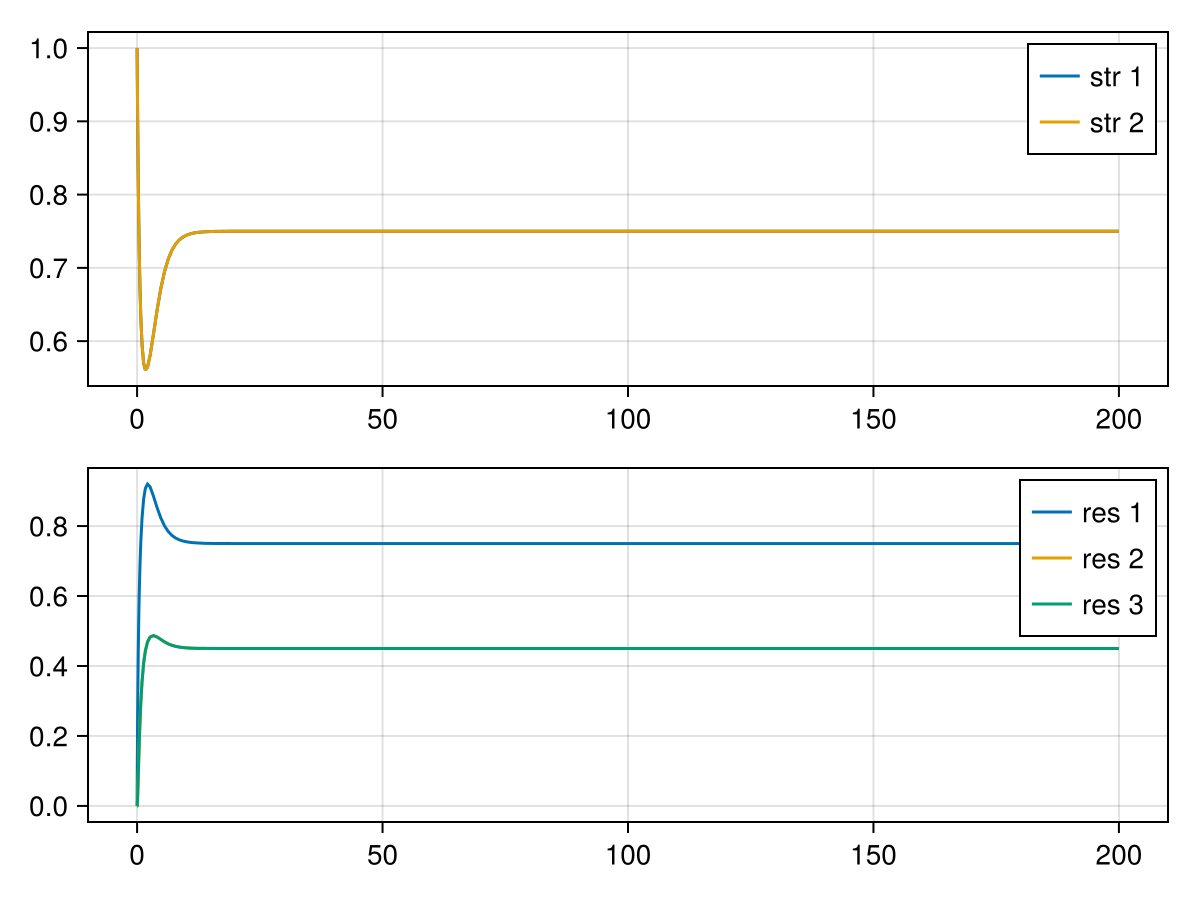

5-element Vector{Float64}:
 0.7499999950837934
 0.7499999950837934
 0.7500000042496404
 0.45000000174241855
 0.45000000174241855

In [5]:
D = fill(0., 2, 3, 3)
D[1,:,:] .= [0. 0. 0.; 0. 0. 0.; 1 0. 0.]
D[2,:,:] .= [0. 0. 0.; 1. 0. 0.; 0. 0. 0.]
params = make_sammicrmparams(2, 3;
    D=SArray{Tuple{2,3,3}}(D),
    K=[3., 0., 0.],
    r=[1., 1., 1.],
    l=[1. 0. 0.; 1. 0. 0.],
    c=[2. 2. 0.; 2. 0. 2.],
    m=[0.9, 0.9],
)

u0 = make_u0_smart(params;
    u0=[1., 1., 0., 0., 0.],
    u0rand=0.
)

p = make_mmicrm_problem(params, u0, 200)
s = solve(p)

check_mmicrmparams(params)
display(plot_mmicrm_sol(s))
s[end]
# param_summary(p.p)

#### Steady state solving

In [14]:
symsol = symbolic_solve_ode_ml(p)

┌ Warning: Solve::ratnz: Solve was unable to solve the system with inexact coefficients.
│     The answer was obtained by solving a corresponding exact system and
│     numericizing the result.
└ @ MathLink ~/.julia/packages/MathLink/NPkhq/src/eval.jl:16


3-element Vector{Vector{Pair{Symbolics.Num, Symbolics.Num}}}:
 [u1 => 0.75, u2 => 0.75, u3 => 0.75, u4 => 0.45, u5 => 0.45]
 [u1 => 0.16666666666666666, u2 => 0.16666666666666666, u3 => 1.8, u4 => 0.45, u5 => 0.45]
 [u1 => 0.0, u2 => 0.0, u3 => 3.0, u4 => 0.0, u5 => 0.0]

In [15]:
sssol = solve(SteadyStateProblem(p), DynamicSS())
show(sssol)

[0.7499991588608942, 0.7499991588608942, 0.7500007386390256, 0.4500002918297526, 0.4500002918297526]

## Spatial stuff

In [17]:
Ds = SA[0.01, 0.01, 1e2, 1., 1.];
usol = s.u[end]

5-element Vector{Float64}:
 0.7499999950837934
 0.7499999950837934
 0.7500000042496404
 0.45000000174241855
 0.45000000174241855

In [29]:
da_get_diff_lengthscales_simple(params, Ds, usol)

(0.038729833537055926, Inf)

### Linear stability analysis

In [25]:
ks = LinRange(0., 10., 10000)
usol = s.u[end]
#usol = sssol.u
#usol = Symbolics.value.(getindex.(symsol[2], 2))
show(uninplace(mmicrmfunc!)(usol, p.p, 0))

[2.613627797042001e-9, 2.613627797042001e-9, -2.2499420104793444e-9, -9.313096960283929e-10, -9.313096960283929e-10]

In [20]:
lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.5, 0.5))
#xlims!(faa.axis, (0., 2.))
faa

LoadError: UndefVarError: `do_linstab_for_ks` not defined

In [6]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

(676, 0.6750675067506751)

In [7]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

5-element Vector{ComplexF64}:
   0.6976388793421477 + 0.0im
   0.6976388793421481 + 0.0im
 -0.04202082925366469 + 0.0im
   0.1114321272553347 + 0.0im
  0.11143212725533479 + 0.0im

### Spatial stuff - 1D!

In [13]:
ssize = (4000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)

space = make_cartesianspace_smart(length(ssize); dx=0.05, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing

sparams = SASMMiCRMParams(params, Ds, space, usenthreads)

sp = make_smmicrm_problem(sparams, su0, 10000)

size(sp.u0), sp.p.usenthreads, sp.p.space

((5, 4000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.05]))

#### Direct solver

  0.326244 seconds (305.96 k allocations: 253.569 MiB, 30.61% gc time)
Success
nf is 34
solution has 10 saved states
max resid is 1.77358e-14


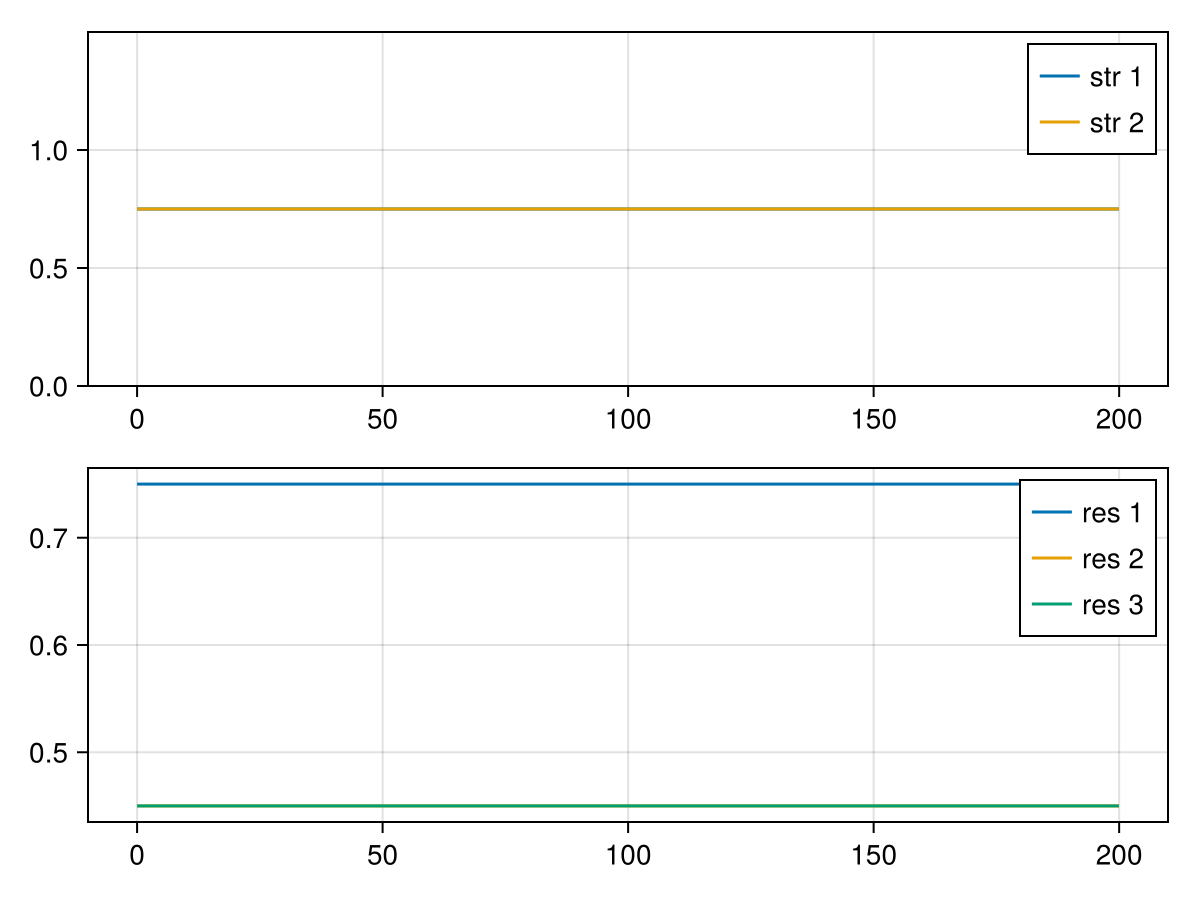

In [23]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

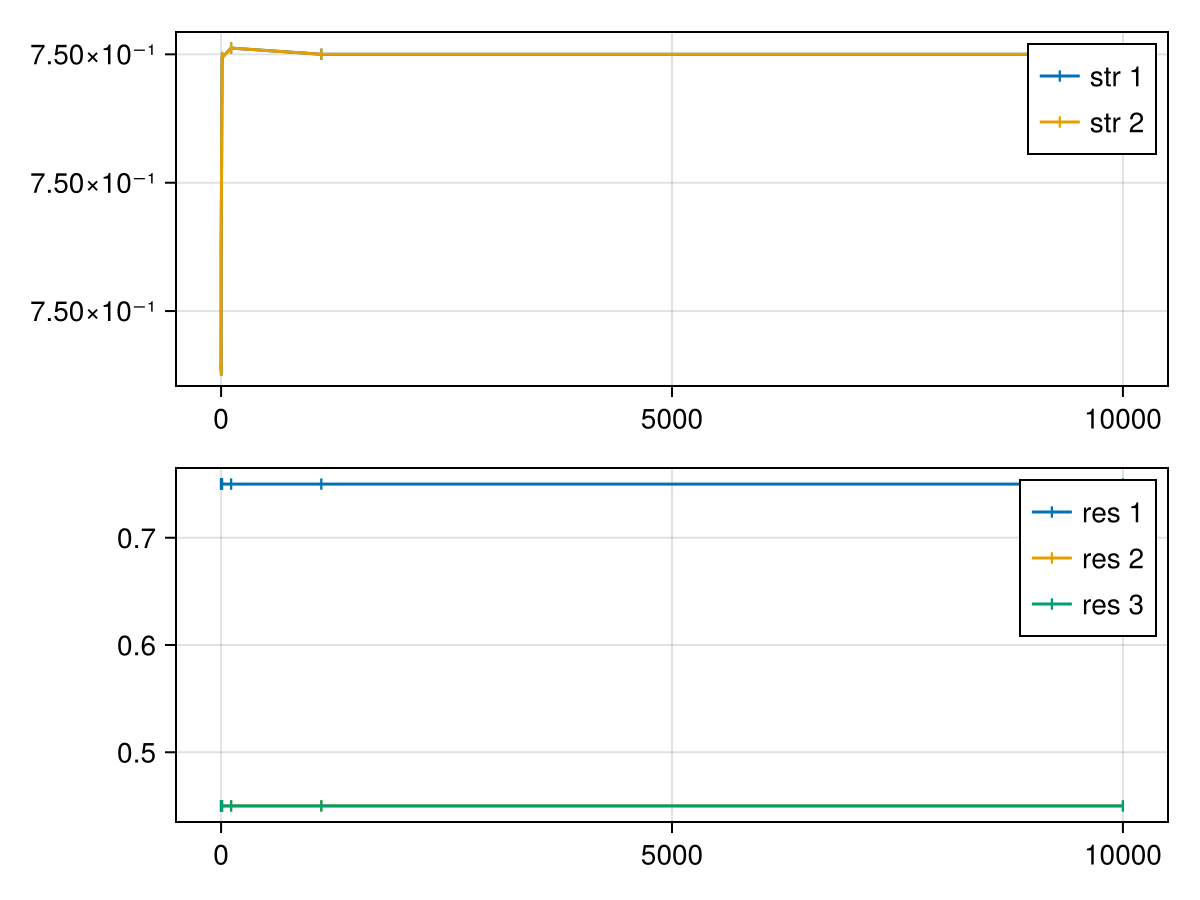

In [24]:
plot_smmicrm_sol_avgs(sps)

#### Steady state solver

 12.204321 seconds (836.84 k allocations: 2.199 GiB, 1.90% gc time)


ReturnCode.Success = 1

2803

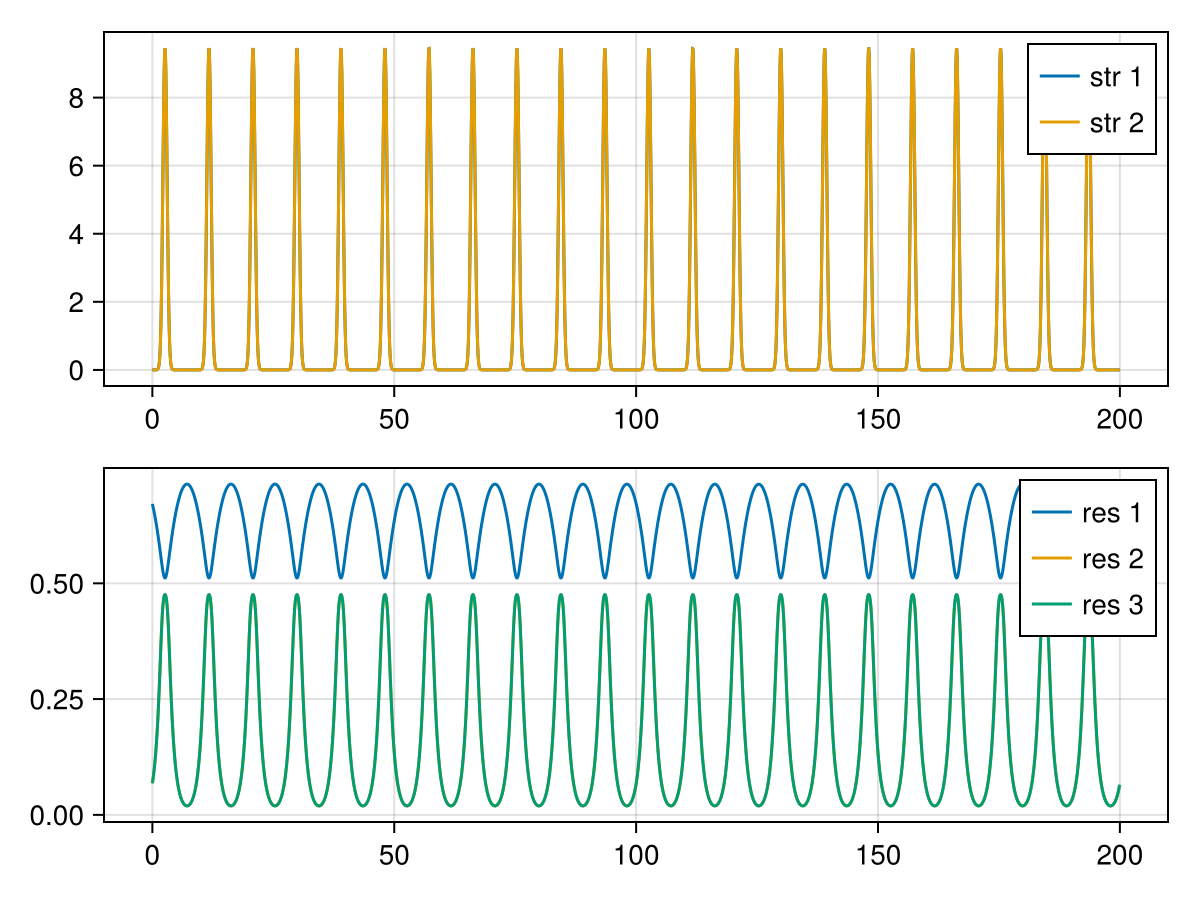

In [87]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

### Spatial stuff - 2D!

In [288]:
ssize = (70,70)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.01, 0.01)
space = make_cartesianspace_smart(length(ssize); dx=0.3, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 100000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((5, 70, 70), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.3, 0.3]))

#### Direct solver

In [289]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
#display(plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end-1]))
#plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

 81.901260 seconds (717.11 k allocations: 9.594 GiB, 1.70% gc time, 0.00% compilation time)


ReturnCode.Success = 1

2196

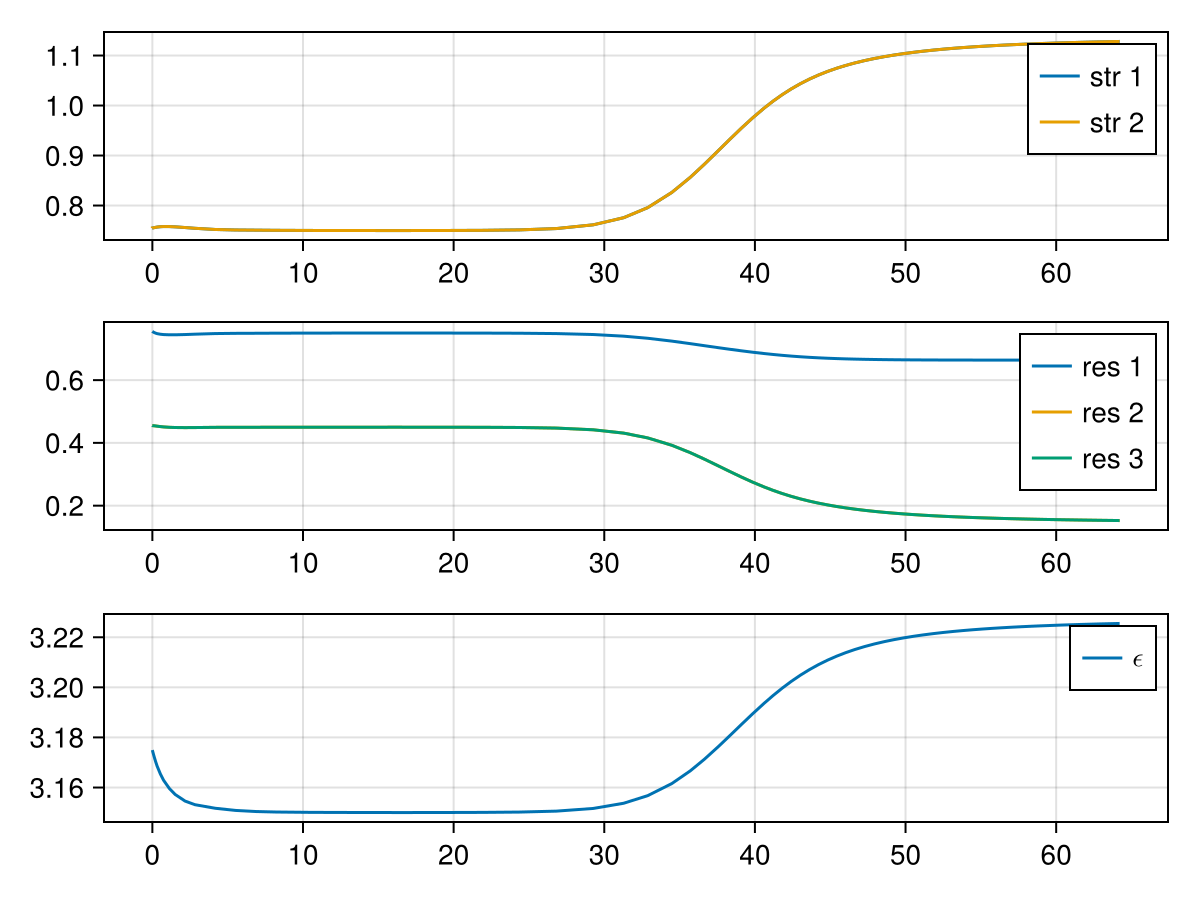

In [290]:
plot_smmicrm_sol_avgs(sps, 1:80; plote=true)

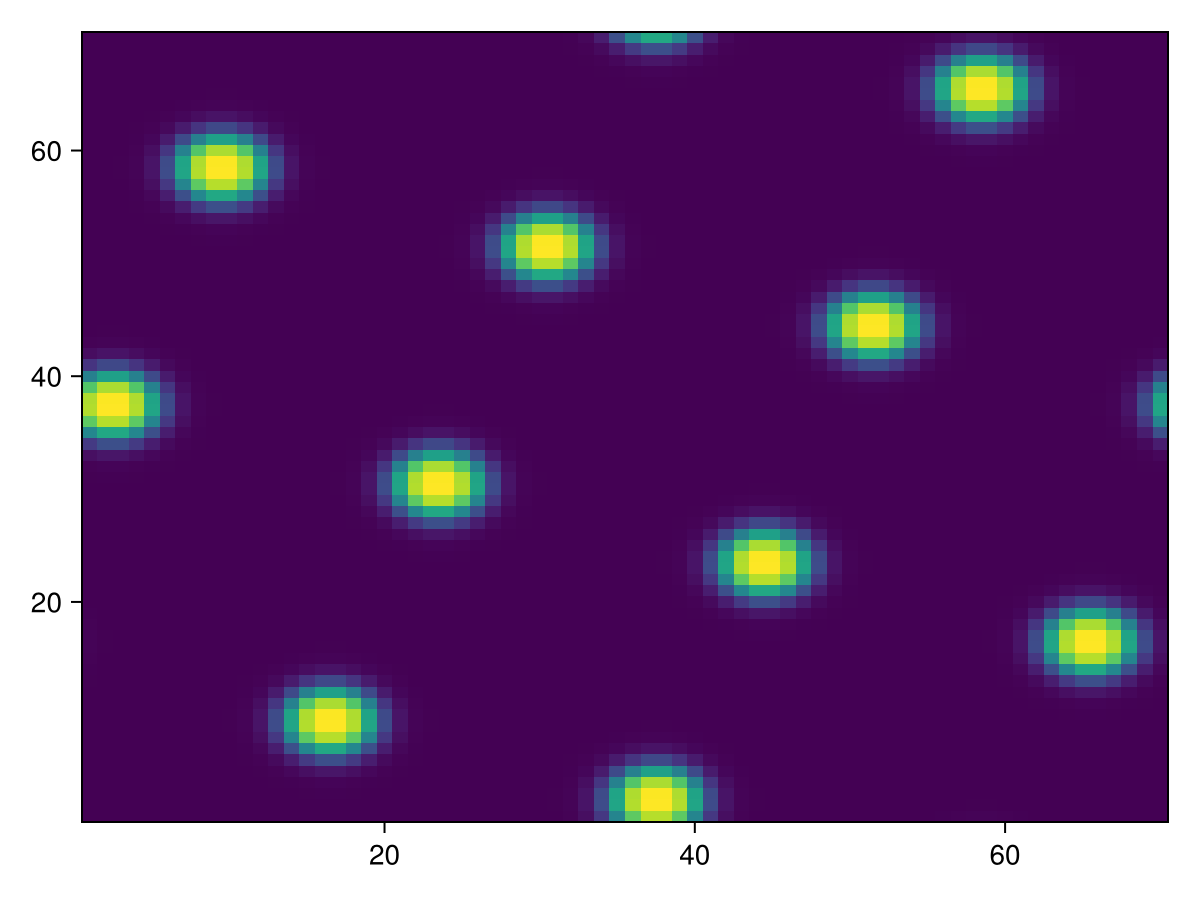

In [296]:
heatmap(sps.u[end][1,:,:])

In [264]:
sps.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  1711
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    82
Number of linear solves:                           912
Number of Jacobians created:                       30
Number of nonlinear solver iterations:             625
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          226
Number of rejected steps:                          7

# Extras

In [263]:
GC.gc()
empty!(Out)

Dict{Int64, Any}()